# W207 Group Project: True vs Fake News 
#### Members: Akiko Iwamizu, Allison Fox, Jason Yang, Rohin Chabra

## Project Background

Our goal for this project was to use labeled news datasets to make an algorithm that is able to determine if an article is fake news or real news. To build the model, we used a dataset provided by Kaggle. During the model development process, we explored performance of Logistic, Naive Bayes, and KNN models, along with unigram, bigram, and trigram feature vectors for text representation. To test the generalizability of the model, we then evaluated the model against a second dataset provided by Kaggle.

## Data Background

### Dataset 1
* Provided by Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Contents: two data sets -- one that includes fake news and one that includes real news
* primary focus of our analysis

### Dataset 2
* Provided by Kaggle: https://www.kaggle.com/c/fake-news/code
* Contents: two data sets -- one that includes train data and one that includes test data
* supplementary dataset to explore generalizability of the models

In [1]:
# Load libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import time
import re
import string
import nltk
import unicodedata

from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

## Import Dataset 1 

In [2]:
# Read in fake news data file.
fake_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/Fake.csv.zip") 
fake = pd.read_csv(fake_zip.open("Fake.csv"))
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read in true news data file.
true_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/True.csv.zip") 
true = pd.read_csv(true_zip.open("True.csv"))
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Create label columns for the fake news data set.
fake["label"] = "false"
fake["label_bin"] = 0
fake.shape

(23481, 6)

In [5]:
# Print the count of fake records by subject. 
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [6]:
# Create label columns for the true news data set.
true["label"] = "true"
true["label_bin"] = 1
true.shape

(21417, 6)

In [7]:
# Print the count of true records by subject.
true['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [8]:
# Merge + combine data sets into one.
data = [fake, true]
df = pd.concat(data, ignore_index=True)
df.shape

(44898, 6)

## Clean & Process Dataset 1

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   label      44898 non-null  object
 5   label_bin  44898 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [10]:
# Confirm the population of each column.
print(f"Null records:\n{df.isna().sum()}\n")
print(f"Empty text records: {len(df[df['text'] == ' '])}\n")
print(f"Empty title records: {len(df[df['title'] == ''])}")

Null records:
title        0
text         0
subject      0
date         0
label        0
label_bin    0
dtype: int64

Empty text records: 627

Empty title records: 0


In [11]:
# Find & remove records where the cleaned text or title column values are empty or NULL.
print(f"Number of text records with a URL: {df['text'].str.count('http|www').sum()}")
print(f"Number of title records with a URL: {df['title'].str.count('http|www').sum()}")
print(f"Number of date records with a URL: {df['date'].str.count('http|www').sum()}")

Number of text records with a URL: 5492
Number of title records with a URL: 9
Number of date records with a URL: 9


In [12]:
# Find records where date column values are invalid.
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
print(f"Number of invalid date records: {len(df.loc[df['date'].isnull()])}")
df.loc[df['date'].isnull()].head(20)

Number of invalid date records: 10


,title,text,subject,date,label,label_bin
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,false,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,false,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,false,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,false,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0


In [13]:
# Remove records where date column values are invalid.
df = df.dropna(subset=["date"])
df.shape

(44888, 6)

In [14]:
# Explore the date column.
df["date"].describe()

count          44888
unique          1010
top       2017-12-20
freq             197
Name: date, dtype: object

In [15]:
# Combine the title and text columns into one column.
df['titletext'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,label,label_bin,titletext
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,false,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,false,0,Pope Francis Just Called Out Donald Trump Dur...


In [16]:
# Check for special characters in the the title and text columns that look like social posts.
print(f"Number of times titletext records contain '@' or '#': {df['text'].str.count('#|@').sum()}")

Number of times titletext records contain '@' or '#': 37616


In [17]:
df[df["titletext"].str.contains("#|@")]

,title,text,subject,date,label,label_bin,titletext
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,Donald Trump Sends Out Embarrassing New Year’...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,Trump Is So Obsessed He Even Has Obama’s Name...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,2017-12-23,false,0,"Fresh Off The Golf Course, Trump Lashes Out A..."
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,2017-12-22,false,0,Former CIA Director Slams Trump Over UN Bully...
...,...,...,...,...,...,...,...
43706,More than 50 arrested for looting in Miami dur...,MIAMI (Reuters) - Miami area police arrested m...,worldnews,2017-09-12,true,1,More than 50 arrested for looting in Miami dur...
44341,Hashtag politics: Merkel tries to get in with ...,"BERLIN (Reuters) - After 12 years in power, Ch...",worldnews,2017-09-06,true,1,Hashtag politics: Merkel tries to get in with ...
44438,Spain pushes EU to adopt restrictive measures ...,MADRID (Reuters) - Spain is pushing for the Eu...,worldnews,2017-09-05,true,1,Spain pushes EU to adopt restrictive measures ...
44636,Exclusive: Displaced Rohingya in camps face ai...,"SITTWE, Myanmar (Reuters) - Around 120,000 dis...",worldnews,2017-09-01,true,1,Exclusive: Displaced Rohingya in camps face ai...


In [18]:
# Function for cleaning text inputs.
def preprocess_text(text_1):
    """Use regex and other tools for pre-processing of the text."""
    # Apply lowercasing.
    text = text_1.lower()
    
    # Replace stop words with empty strings.
    pattern = re.compile(r"\b(" + r"|".join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Replace punctuation with empty strings.
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Replace all non-alphanumeric characters with a single space.
    text = re.sub(r"[^a-z0-9]+", " ", text)
    
    # Replace large, consecutive amounts of whitespace with a single space.
    text = re.sub(r"[\s]+", " ", text)
    
    # Remove leading and trailing whitespace.
    text = text.strip()
    
    return text

In [19]:
# Clean up text features.
nltk.download("stopwords")

start_time = time.time()
stop_words = set(stopwords.words("english"))

df["clean_title"] = df["title"].apply(lambda text: preprocess_text(text))
df["clean_text"] = df["text"].apply(lambda text: preprocess_text(text))
df["clean_titletext"] = df["titletext"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


58.942 seconds to execute pre-processing text inputs...


In [20]:
# Remove single character words.
pd.options.display.max_colwidth = 500
def singlecharacter(text):
    final_text = []
    words = text.split()
    for i in words:
        if len(i) > 1:
            final_text.append(i)
    return " ".join(final_text)

df['clean_text'] = df['clean_text'].apply(singlecharacter)

In [21]:
# View the cleaned dataset.
df.head()

,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be ...",News,2017-12-31,false,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Med...",donald trump sends embarrassing new year eve message disturbing,donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america do...,donald trump sends embarrassing new year eve message disturbing donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest f...
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar whe...",News,2017-12-31,false,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former ...",drunk bragging trump staffer started russian collusion investigation,house intelligence committee chairman devin nunes going bad day assumption like many us christopher steeledossier prompted russia investigation lashing department justice fbi order protect trump happens dossier started investigation according documents obtained new york timesformer trump campaign adviser george papadopoulos drunk wine bar revealed knowledge russian opposition research hillary clintontop papadopoulos covfefe boy trump administration alleged much larger role none damning drunk...,drunk bragging trump staffer started russian collusion investigation house in

In [22]:
df["clean_text"].describe()

count     44888
unique    38362
top            
freq        632
Name: clean_text, dtype: object

In [23]:
df["clean_title"].describe()

count                                           44888
unique                                          38709
top       factbox trump fills top jobs administration
freq                                               14
Name: clean_title, dtype: object

In [24]:
# Get count of empty clean text records.
print(f"Empty clean text records: {len(df[df['clean_text'] == ''])}")
df[df["clean_text"] == ""].head()

Empty clean text records: 632


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext
10923,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,,politics,2017-05-10,false,0,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,take poll think president trump pick replace james comey,,take poll think president trump pick replace james comey
11041,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],,politics,2017-04-26,false,0,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],joe scarborough berates mika brzezinski cheap shot ivanka trump snotty video,,joe scarborough berates mika brzezinski cheap shot ivanka trump snotty video
11190,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],,politics,2017-04-06,false,0,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],watch tucker carlson scorch sanctuary city mayor believe laws video,,watch tucker carlson scorch sanctuary city mayor believe laws video
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],,politics,2017-04-02,false,0,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],mayor sanctuary city trump trying make us fugitive slave catchers video,,mayor sanctuary city trump trying make us fugitive slave catchers video
11236,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],,politics,2017-04-01,false,0,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],shocker public school turns computer lab mosque bars nonmuslim students video,,shocker public school turns computer lab mosque bars nonmuslim students video


In [25]:
# Remove empty clean text records.
df = df[df["clean_text"] != ""]

# Confirm count of empty clean text records.
print(f"Empty clean text records (after removal): {len(df[df['clean_text'] == ''])}")
print(f"Filtered df size: {df.shape}")
df[df["clean_text"] == ""].head()

Empty clean text records (after removal): 0
Filtered df size: (44256, 10)


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [26]:
# Get count of empty clean title records.
print(f"Empty clean title records: {len(df[df['clean_title'] == ''])}")
df[df["clean_title"] == ""].head()

Empty clean title records: 0


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [27]:
# Get count of special characters in the cleaned text column that look like social posts.
print(f"Number of times clean_text records contain '@' or '#': {df['clean_text'].str.count('#|@').sum()}")

Number of times clean_text records contain '@' or '#': 0


There are 36959949 words across all the articles.


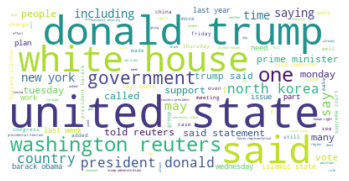

In [28]:
# Create a word cloud of all the true records.
truefilt = df[(df['label_bin'] == 1)]
text = " ".join(article for article in truefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 40978019 words across all the articles.


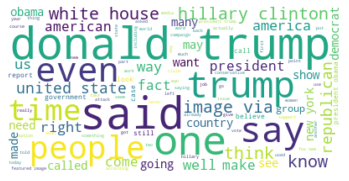

In [29]:
# Create a word cloud of all the fake records.
fakefilt = df[(df['label_bin'] == 0)]
text = " ".join(article for article in fakefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Split Train, Test, & Dev Data for Dataset 1

In [30]:
# Split cleaned data set into train (70%), test (15%), & dev (15%).
# Use random_state param to reproduce shuffle outcomes.
train, test = train_test_split(df, random_state=0, train_size=0.7, test_size=0.3, shuffle=True)
num_test = int(len(test)/2)
test = test[num_test:]
dev = test[:num_test]

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Dev data shape:", dev.shape)

Train data shape: (30979, 10)
Test data shape: (6639, 10)
Dev data shape: (6638, 10)


In [31]:
# Export train, test, & dev data sets to dir.
# Write a Pandas DataFrame as a zipped CSV file.
# train.to_csv("input/processed-datasets/train.csv", index=False)
# test.to_csv("input/processed-datasets/test.csv", index=False)
# dev.to_csv("input/processed-datasets/dev.csv", index=False)

## Exploratory Data Analysis for Dataset 1

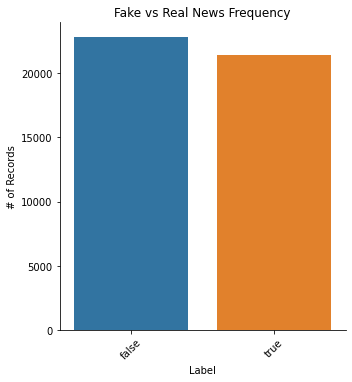

In [32]:
# Histograms looking at the distribution of fake vs real news labels.
g = sns.catplot(data=df, x="label", kind="count")
g.set(xlabel="Label", ylabel="# of Records", title="Fake vs Real News Frequency")
g.set_xticklabels(rotation=45)

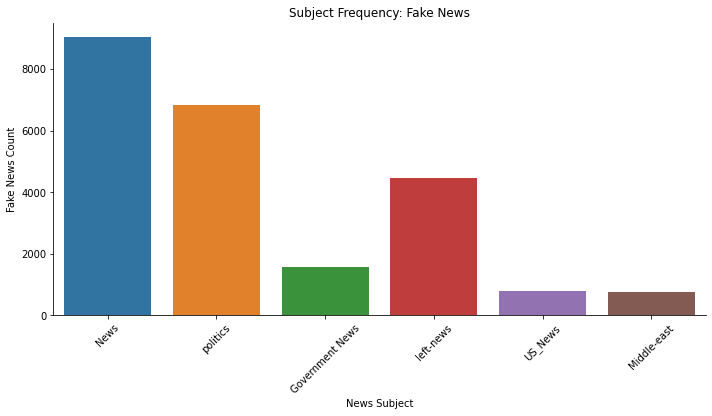

In [33]:
# Histogram looking at the frequency of fake news subjects.
g = sns.catplot(data=fake, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="Fake News Count", title="Subject Frequency: Fake News")
g.set_xticklabels(rotation=45)

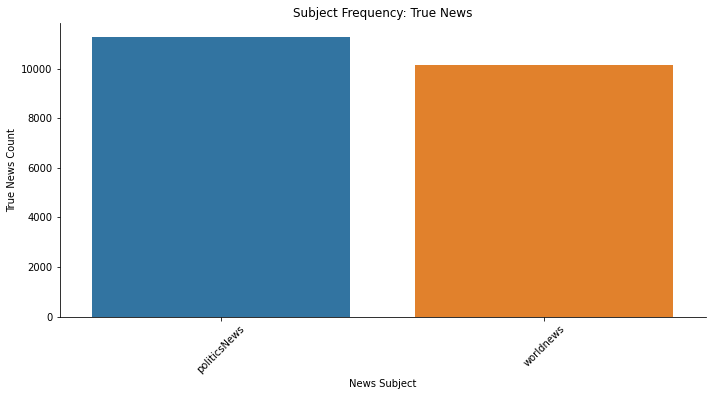

In [34]:
# Histogram looking at the frequency of true news subjects.
g = sns.catplot(data=true, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="True News Count", title="Subject Frequency: True News")
g.set_xticklabels(rotation=45)

Though there is no overlap in subjects between fake news and real news, we don't see this as something that will pose a concern since we are not including the subject of the article in the model.

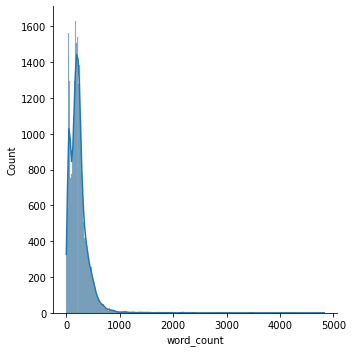

In [35]:
# Distribution of the word count of the clean text values of the news data.
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df["word_count"], kde=True)
fig = plt.gcf()

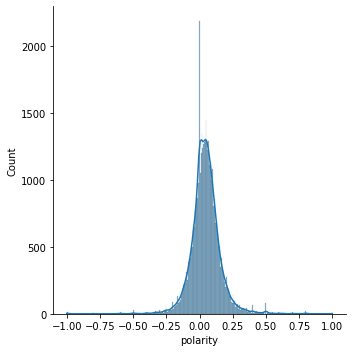

In [36]:
# Distribution of the polarity of the clean text values of the news data. 
# Appears to be neutral on average.
df["polarity"] = df["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(df["polarity"], kde=True)
fig = plt.gcf()

Word count in longest real article: 2392
Word count in longest fake article: 4830


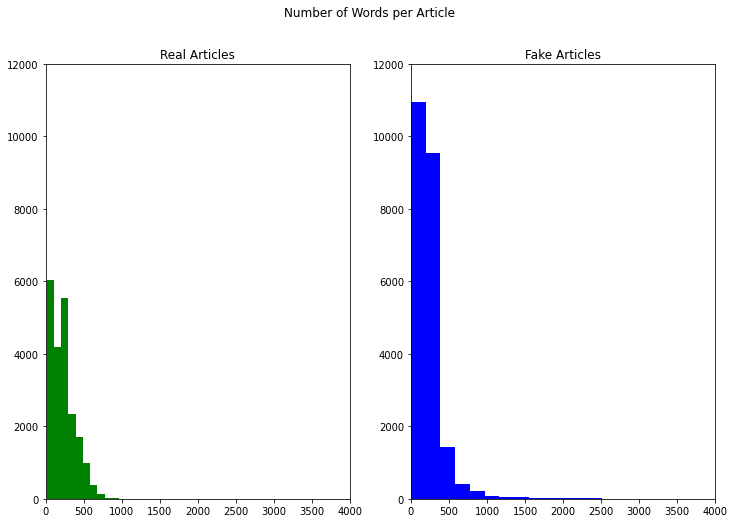

In [37]:
# Histogram of word length in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 12000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 4000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Words per Article')
plt.show()

Character count in longest real article: 17958
Character count in longest fake article: 38702


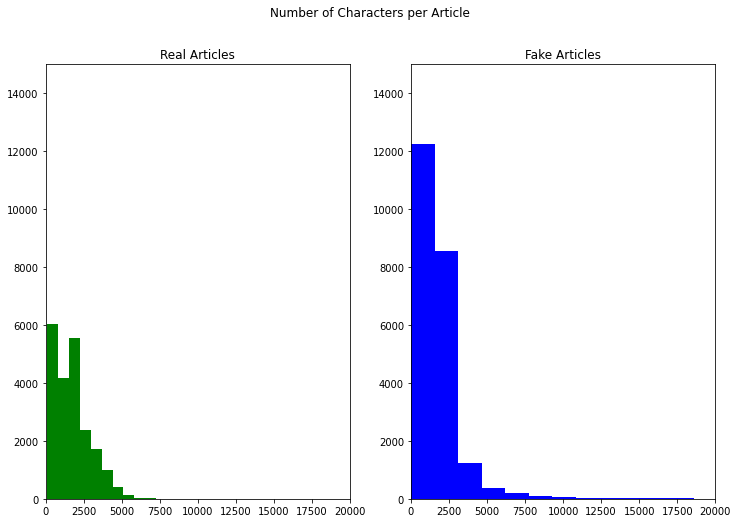

In [38]:
# Histogram of character count in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 15000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 20000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.len()
print("Character count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.len()
print("Character count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Characters per Article')
plt.show()

### Word Counts
Get the Top 10 words for real and fake news datasets

In [39]:
df_word_cnt_true = df[df['label']=='true']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_true.columns = ['word', 'freq']
df_word_cnt_true.head(10)

,word,freq
0,said,99010
1,trump,54265
2,would,31507
3,reuters,28402
4,president,26527
5,state,19773
6,government,18305
7,new,16778
8,states,16625
9,house,16552


In [40]:
df_word_cnt_false = df[df['label']=='false']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_false.columns = ['word', 'freq']
df_word_cnt_false.head(10)

,word,freq
0,trump,72947
1,said,30697
2,people,25760
3,president,25291
4,would,23222
5,one,22494
6,clinton,17814
7,obama,17547
8,like,17513
9,donald,16999


# Import Dataset 2

In [41]:
# Read in test dataset. Test dataset does not have label
test_zip = zipfile.ZipFile("./input/fake-news-dataset2/test.csv.zip") 
test = pd.read_csv(test_zip.open("test.csv"))
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times",David Streitfeld,"PALO ALTO, Calif. — After years of scorning the political process, Silicon Valley has leapt into the fray. The prospect of a President Donald J. Trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists. A distinguished venture capital firm emblazoned on its corporate home page an earthy epithet. One prominent tech chieftain says the consequences of Mr. Trump’s election would “range between disastrous and ..."
1,20801,Russian warships ready to strike terrorists near Aleppo,NaN,"Russian warships ready to strike terrorists near Aleppo 08.11.2016 | Source: Source: Mil.ru Attack aircraft of the Russian aircraft carrier Admiral Kuznetsov get ready to strike terrorists' positions in the vicinity of Aleppo, sources at the Russian Defense Ministry said, RBC reports. ""Insurgents' attempts to break into Aleppo from outside are meaningless,"" the source said. The main task of the aircraft carrier aviation group is to strike missile and air blows on the terrorists , whose goal ..."
2,20802,"#NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police",Common Dreams,"Videos #NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police Amnesty International are sending a delegation of human rights observers to monitor the response of law enforcement to the protests. Be Sociable, Share! (Rob Wilson photo) \nNative American leaders vowed on Saturday to protest through the winter against a North Dakota oil pipeline they say threatens water resources and sacred lands and are planning lawsuits over police treatment of arrested protesters..."
3,20803,"Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. He will hold a workout for M. L. B. teams this month, his agents told ESPN and other news outlets. “This may sound like a publicity stunt, but nothing could be further from the truth,” said Brodie Van Wagenen, of CAA Baseball, part of the sports agency CAA Sports, in the statement..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,"42 mins ago 1 Views 0 Comments 0 Likes 'For the first time in history, we’re filming a panoramic video from the station. It means you’ll see everything we see here, with your own eyes. That’s to say, you’ll be able to feel like real cosmonauts' - Borisenko to RT. Video presented by RT in collaboration with the Russian space agency Roscosmos and the rocket and space corporation Energia More on our project website: space360.rt.com Subscribe Like Leave a Reply Login with your Social ID ..."


In [42]:
# Read in Train dataset
# label: 1: unreliable ; 0:reliable
train_zip = zipfile.ZipFile("./input/fake-news-dataset2/train.csv.zip") 
df_test2 = pd.read_csv(train_zip.open("train.csv"))
df_test2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well....",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduat...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but t...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the bi...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,"Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Guard searched her home and found a notebook that contained a fictional story she’d written about a woman who was stoned to death, according to the Eurasia Review . \nGolrokh Ebrahimi Iraee, 35, is the wife of political prisoner Arash Sadeghi, 36, who is serving a 19-year prison sentence for being a human rights activist, the publication reported. \n“When the intelligence unit of the Revolutionary G...",1


In [43]:
# Update labels to match original dataset. 
df_test2['label_bin'] = df_test2.head()['label'].map({1:0 , 0:1})
df_test2['label'] = df_test2.head()['label'].map({1:'false' , 0:'true'})

In [44]:
df_test2.head()

,id,title,author,text,label,label_bin
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well....",false,0.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduat...",true,1.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but t...",false,0.0
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the bi...,false,0.0
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,"Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Guard searched her home and found a notebook that contained a fictional story she’d written about a woman who was stoned to death, according to the Eurasia Review . \nGolrokh Ebrahimi Iraee, 35, is the wife of political prisoner Arash Sadeghi, 36, who is serving a 19-year prison sentence for being a human rights activist, the publication reported. \n“When the intelligence unit of the Revolutionary G...",false,0.0


In [45]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20800 non-null  int64  
 1   title      20242 non-null  object 
 2   author     18843 non-null  object 
 3   text       20761 non-null  object 
 4   label      5 non-null      object 
 5   label_bin  5 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 975.1+ KB


## Clean & Process Dataset 2

In [46]:
# Check for empty records.
df_test2.isna().sum().sum()

44144

In [54]:
# Check columns labeled as the 'object' dtype.
df_test2["title"].apply(type).value_counts()

<class 'str'>      20242
<class 'float'>      558
Name: title, dtype: int64

In [59]:
# Inspect float objects in title column.
df_test2_inspect_nulls = df_test2[df_test2.isna().any(axis=1)]
df_test2_inspect_nulls.head()

,id,title,author,text,label,label_bin,titletext
5,5,Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first. “If he decides to bomb them, the whole country will be behind him, because everybody will realize he had no choice and that was the only thing to do,” Jackie says. “Except the Hollywood left. They’ll get nauseous...",NaN,NaN,"Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first. “If he decides to bomb them, the whole country will be behind him, because everybody wi..."
6,6,"Life: Life Of Luxury: Elton John’s 6 Favorite Shark Pictures To Stare At During Long, Transcontinental Flights",NaN,"Ever wonder how Britain’s most iconic pop pianist gets through a long flight? Here are the six pictures of sharks Sir Elton John likes to stare at to pass the time on an airplane. 1. A Shark Swimming \nSit next to Elton John on a flight and you’ll see a man living in the lap of luxury, as he immediately tapes this photo of a shark darting through the ocean over his window to stare at throughout the trip. The platinum-selling artist has been known to pull his window shade down to make the sha...",NaN,NaN,"Life: Life Of Luxury: Elton John’s 6 Favorite Shark Pictures To Stare At During Long, Transcontinental Flights Ever wonder how Britain’s most iconic pop pianist gets through a long flight? Here are the six pictures of sharks Sir Elton John likes to stare at to pass the time on an airplane. 1. A Shark Swimming \nSit next to Elton John on a flight and you’ll see a man living in the lap of luxury, as he immediately tapes this photo of a shark darting through the ocean over his window to stare a..."
7,7,Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times,Alissa J. Rubin,"PARIS — France chose an idealistic, traditional candidate in Sunday’s primary to represent the Socialist and parties in the presidential election this spring. The candidate, Benoît Hamon, 49, who ran on the slogan that he would “make France’s heart beat,” bested Manuel Valls, the former prime minister, whose campaign has promoted more policies and who has a strong background. Mr. Hamon appeared to have won by a wide margin, with incomplete returns showing him with an estimated 58...",NaN,NaN,"Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times PARIS — France chose an idealistic, traditional candidate in Sunday’s primary to represent the Socialist and parties in the presidential election this spring. The candidate, Benoît Hamon, 49, who ran on the slogan that he would “make France’s heart beat,” bested Manuel Valls, the former prime minister, whose campaign has promoted more policies and who has a strong background. Mr. Hamon appeare..."
8,8,Excerpts From a Draft Script for Donald Trump’s Q&ampA With a Black Church’s Pastor - The New York Times,NaN,"Donald J. Trump is scheduled to make a highly anticipated visit to an church in Detroit on Saturday, the first such visit of his campaign. There, he will participate in a session conducted by Bishop Wayne T. Jackson of the church, Great Faith Ministries International. Given the importance of the visit, the Trump team went so far as to script Mr. Trump’s answers to Bishop Jackson’s questions, which were submitted in advance. After this article was pub

In [ ]:
# Remove empty clean text records.
# df = df[df["clean_text"] != ""]

# Confirm count of empty clean text records.
# print(f"Empty clean text records (after removal): {len(df[df['clean_text'] == ''])}")
# print(f"Filtered df size: {df.shape}")
# df[df["clean_text"] == ""].head()

In [ ]:
# Convert float items in title and text columns to ensure all values are of type string.
#for col in df.select_dtypes(include=['object']).columns:
    #df[col] = df[col].fillna('unknown')

In [55]:
# Check columns labeled as the 'object' dtype.
df_test2["text"].apply(type).value_counts()

<class 'str'>      20761
<class 'float'>       39
Name: text, dtype: int64

In [47]:
# DONT DO THIS COMMAND - IT DROPS 44K RECORDS!
#df_test2 = df_test2.dropna()

In [48]:
# Combine the title and text columns into one column.
df_test2['titletext'] = df_test2['title'] + ' ' + df_test2['text']

# Clean up text features.
start_time = time.time()
stop_words = set(stopwords.words("english"))

df_test2["clean_title"] = df_test2["title"].apply(lambda text: preprocess_text(text))
df_test2["clean_text"] = df_test2["text"].apply(lambda text: preprocess_text(text))
df_test2["clean_titletext"] = df_test2["titletext"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
df_test2['clean_text'] = df_test2['clean_text'].apply(singlecharacter)

In [ ]:
df_test2.head(2)

In [ ]:
# Get count of empty clean text records.
print(f"Empty clean text records: {len(df_test2[df_test2['clean_text'] == ''])}")
df_test2[df_test2["clean_text"] == ""].head()

In [ ]:
# Get count of empty clean title records.
print(f"Empty clean title records: {len(df_test2[df_test2['clean_title'] == ''])}")
df_test2[df_test2["clean_title"] == ""].head()

In [ ]:
# Get count of special characters in the the title and text columns that look like social posts.
print(f"Number of times clean_text records contain '@' or '#': {df_test2['clean_text'].str.count('#|@').sum()}")

In [ ]:
df_test2.shape

# EDA for Dataset 2

In [ ]:
# See the counts of true and fake news articles.
pd.pivot_table(df_test2, values="id", index="label", aggfunc="count")

In [ ]:
# Create a word cloud of all the true records.
truefilt = df_test2[(df_test2['label_bin'] == 1)]
text = " ".join(article for article in truefilt.clean_text)

# Print the number of words across all the articles
print ("There are {} words across all the true articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Create a word cloud of all the fake records.
fakefilt = df_test2[(df_test2['label_bin'] == 0)]
text = " ".join(article for article in fakefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the fake articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Distribution of the polarity of the clean text values of the fake news data. 
# Appears to be neutral on average.
truefilt["polarity"] = truefilt["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(truefilt["polarity"], kde=True)
fig = plt.gcf()

In [ ]:
# Distribution of the polarity of the clean text values of the fake news data. 
# Appears to be neutral on average.
fakefilt["polarity"] = fakefilt["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(fakefilt["polarity"], kde=True)
fig = plt.gcf()

In [ ]:
# Distribution of the word count of the clean text values of the news data.
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df["word_count"], kde=True)
fig = plt.gcf()

# Modeling

We began by modeling Dataset 1 using Logistic, Naive Bayes, and K-Nearest Neigbors for Unigram, Bigram, and Trigram feature vector text representations.

In [ ]:
train.head(1)
start_1=time.time()

<h2>Modeling with Unigram words</h2>

In [ ]:
from sklearn.feature_extraction import text ## Need to re-import because we overwrite text variable in a previous preprocessing function
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)

model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)

<h4> Logistic Model </h4>

In [ ]:
f1_score_1=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Unigram F1-score:',f1_score_1)

weights=model_lr.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() 
topic_words=cv.get_feature_names_out()[sorted_weights]  
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_lr_1=pd.DataFrame() #create dataframe
df_topics_lr_1['words']=pd.DataFrame(topic_words)
for i in range(1): 
    specific_weight=weights[i][sorted_weights] 
    df_topics_lr_1[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) 
display(df_topics_lr_1) #showcase the topics and the words for the feature

<h4> Naive Bayes Model </h4>

In [ ]:
df_alpha_stats_1=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_1=df_alpha_stats_1.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_1.to_string(index=False,justify='center'))

weights=nb_model.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() #sort them in order to get the top 5 weights per topic
topic_words=cv.get_feature_names_out()[sorted_weights]
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_1=pd.DataFrame() #create dataframe
df_topics_nb_1['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_1[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_1) #showcase the topics and the words for the feature

<h4> KNN Model </h4>

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_1=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_1 = df_k_stats_1.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_1.to_string(index=False,justify='center'))

<h2>Modeling with Bigram words</h2>

In [ ]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv_2=CountVectorizer(ngram_range=(2,2),stop_words=stop_words)
X_train=cv_2.fit_transform(corpus_train)
X_test=cv_2.transform(corpus_test)


<h4> Logistic Model </h4>

In [ ]:
model_lr_2=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_2.fit(X_train,y_train)
y_pred=model_lr_2.predict(X_test)
f1_score_2=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Bigram F1-Score',f1_score_2)

<h4> Naive Bayes Model </h4>

In [ ]:
df_alpha_stats_2=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_2=df_alpha_stats_2.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_2.to_string(index=False,justify='center'))

weights=nb_model.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() #sort them in order to get the top 5 weights per topic
topic_words=cv_2.get_feature_names_out()[sorted_weights] #Grab the words from the top 5 weights 
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_2=pd.DataFrame() #create dataframe
df_topics_nb_2['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    print(i)
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_2[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_2) #showcase the topics and the words for the feature

<h4> KNN Model </h4>

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_2=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,5) #Make it pretty
    df_k_stats_2 = df_k_stats_2.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_2.to_string(index=False,justify='center'))

<h2> Modeling with Trigram words </h2>

In [ ]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)
cv_3=CountVectorizer(ngram_range=(3,3),stop_words=stop_words)
X_train=cv_3.fit_transform(corpus_train)
X_test=cv_3.transform(corpus_test)

<h4> Logistic Model </h4>

In [ ]:
model_lr_3=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_3.fit(X_train,y_train)
y_pred=model_lr_3.predict(X_test)
f1_score_3=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Trigram Word F1-Score',f1_score_3)

<h4> Naive-Bayes Model </h4>

In [ ]:
df_alpha_stats_3=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_3=df_alpha_stats_3.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_3.to_string(index=False,justify='center'))

weights=nb_model.coef_ 
sorted_weights=np.argsort(weights)[:,-10:].flatten() 
topic_words=cv_3.get_feature_names_out()[sorted_weights] 
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_3=pd.DataFrame() #create dataframe
df_topics_nb_3['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    print(i)
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_3[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_3) 

<h4> KNN Model </h4>

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_3=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_3 = df_k_stats_3.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_3.to_string(index=False,justify='center'))

<h1> Model Analysis based on Max Features </h1>

In [ ]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

max_features=[10,100,1000,10000,100000]
df_lr_performance=pd.DataFrame()
lr_perf={'Model':'Logistic Regression','Features Count':None,'F1-Score':None,'Performance Time':None}
for i in max_features:
    lr_perf['Features Count']=i
    start = time.time()
    cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words,max_features=i)
    X_train=cv.fit_transform(corpus_train)
    X_test=cv.transform(corpus_test)
    model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
    model_lr.fit(X_train,y_train)
    y_pred=model_lr.predict(X_test)
    duration=time.time()-start
    f1_score=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
    lr_perf['F1-Score']=f1_score
    lr_perf['Performance Time']=duration
    df_lr_performance = df_lr_performance.append(lr_perf, ignore_index=True)
    print(i,duration,f1_score)

#Adding the final performance after 100K features have been added
lr_perf={'Model':'Logistic Regression','Features Count':None,'F1-Score':None,'Performance Time':None}
start = time.time()
cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)
model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)
duration=time.time()-start
f1_score=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
lr_perf['F1-Score']=f1_score
lr_perf['Performance Time']=duration
lr_perf['Features Count']=len(cv.get_feature_names_out())
df_lr_performance = df_lr_performance.append(lr_perf, ignore_index=True)
df_lr_performance['Features Count']=df_lr_performance['Features Count'].astype(int)



In [ ]:
#Graphing and Display Performance with Feature Size

df_lr_performance.plot.line(x='Features Count',y='F1-Score',ylabel='Model F1-Score',title='Performance based on Vocabulary Size',logx=True,color='purple') #Create plot with purple because purple is cool.  
df_lr_performance.plot.line(x='Performance Time',y='F1-Score',ylabel='Model F1-Score',title='Performance based on Duration',logx=False,color='purple') #Create plot with purple because purple is cool.  
display(df_lr_performance)

<h2>F1 Score Analysis with all Models </h2>

In [ ]:
df_all_models=pd.DataFrame()
logistic_models={'Model':None,'Special Characteristic':None,'F1-Score':None}
log_models={'Logistic Model Unigram':f1_score_1,'Logistic Model Bigram':f1_score_2,'Logistic Model Trigram':f1_score_3}
knn_models=[df_k_stats_1,df_k_stats_2,df_k_stats_3]
for i in log_models:
    logistic_models['Model']=i
    logistic_models['F1-Score']=log_models[i]
    df_all_models=df_all_models.append(logistic_models, ignore_index=True)
nb_models=[df_alpha_stats_1,df_alpha_stats_2,df_alpha_stats_3]
count=0
for i in nb_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
count=0
for i in knn_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue

df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['Alpha'])
df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['K-value'])
df_all_models=df_all_models.drop(columns=['Alpha', 'K-value'])
display(df_all_models)


In [ ]:
# Plot F1 score of all models.
df_all_models.plot.bar(x='Model',y='F1-Score',color=['purple','green','orange'],title='F1-Score All Models',legend=False)


In [ ]:
# Print time it takes to run all models.
end_1=time.time()
duration=((start_1-end_1)*-1)/60
print(f'The total time it takes for all of modeling to finish is {duration} minutes')

# Evaluate Models based on Dataset 2

In [ ]:
from sklearn.feature_extraction import text ## Need to re-import because we overwrite text variable in a previous preprocessing function
corpus_train = train['clean_text']
corpus_test = df_test2['clean_text']
y_train = train['label_bin']
y_test = df_test2['label_bin']

additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)

model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)

In [ ]:
f1_score_1=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Unigram F1-score:',f1_score_1)

In [ ]:
df_alpha_stats_1=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_1=df_alpha_stats_1.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_1.to_string(index=False,justify='center'))

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_1=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_1 = df_k_stats_1.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_1.to_string(index=False,justify='center'))

### Evaluation Bi-grams

In [ ]:
corpus_train = train['clean_text']
corpus_test = df_test2['clean_text']
y_train = train['label_bin']
y_test = df_test2['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv_2=CountVectorizer(ngram_range=(2,2),stop_words=stop_words)
X_train=cv_2.fit_transform(corpus_train)
X_test=cv_2.transform(corpus_test)

In [ ]:
model_lr_2=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_2.fit(X_train,y_train)
y_pred=model_lr_2.predict(X_test)
f1_score_2=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Bigram F1-Score',f1_score_2)

In [ ]:
df_alpha_stats_2=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_2=df_alpha_stats_2.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_2.to_string(index=False,justify='center'))

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_2=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,5) #Make it pretty
    df_k_stats_2 = df_k_stats_2.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_2.to_string(index=False,justify='center'))

### Tri-grams

In [ ]:
corpus_train = train['clean_text']
corpus_test = df_test2['clean_text']
y_train = train['label_bin']
y_test = df_test2['label_bin']

additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)
cv_3=CountVectorizer(ngram_range=(3,3),stop_words=stop_words)
X_train=cv_3.fit_transform(corpus_train)
X_test=cv_3.transform(corpus_test)

In [ ]:
model_lr_3=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_3.fit(X_train,y_train)
y_pred=model_lr_3.predict(X_test)
f1_score_3=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Trigram Word F1-Score',f1_score_3)

In [ ]:
df_alpha_stats_3=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_3=df_alpha_stats_3.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_3.to_string(index=False,justify='center'))

In [ ]:
knn_values=[1,3,5,7,9]
df_k_stats_3=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_3 = df_k_stats_3.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_3.to_string(index=False,justify='center'))

In [ ]:
df_all_models=pd.DataFrame()
logistic_models={'Model':None,'Special Characteristic':None,'F1-Score':None}
log_models={'Logistic Model Unigram':f1_score_1,'Logistic Model Bigram':f1_score_2,'Logistic Model Trigram':f1_score_3}
knn_models=[df_k_stats_1,df_k_stats_2,df_k_stats_3]
for i in log_models:
    logistic_models['Model']=i
    logistic_models['F1-Score']=log_models[i]
    df_all_models=df_all_models.append(logistic_models, ignore_index=True)
nb_models=[df_alpha_stats_1,df_alpha_stats_2,df_alpha_stats_3]
count=0
for i in nb_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
count=0
for i in knn_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue

df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['Alpha'])
df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['K-value'])
df_all_models=df_all_models.drop(columns=['Alpha', 'K-value'])
display(df_all_models)

In [ ]:
# Plot F1 score of all models.
df_all_models.plot.bar(x='Model',y='F1-Score',color=['purple','green','orange'],title='F1-Score All Models',legend=False)

# Limitations and Biases

In [ ]:
INSERT LIMITATIONS HERE.

Training and serving skew. We see that our training dataset is heavily biased with one or two works yielding high accuracy. We pulled in a second dataset to run our model against. Interestingly the Bi and Trigrams in KNN are more performant with the Naive-Bayes Trigram. In other words, a more generalized model seemed to work better when testing with a second dataset

# Next Steps

In [ ]:
INSERT NEXT STEPS HERE.